# Model Parameters

In [1]:
# Max batch size= available GPU memory bytes / 4 / (size of tensors + trainable parameters)
BATCH_SIZE = 8
# MODEL_MODE can be "TRAIN" to train model or anything else to load existing weights
MODEL_MODE = 'LOAD'
# Load path is used when model mode is not "TRAIN"
LOAD_PATH = './seg_model_weights.thebest.hdf5'
EDGE_CROP = 16
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = (1, 1)
# downsampling in preprocessing
IMG_SCALING = (2, 2) # (3, 3)
# number of validation images to use
VALID_IMG_COUNT = 2000
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 50
MAX_TRAIN_EPOCHS = 100
# brightness can be problematic since it seems to change the labels differently from the images
AUGMENT_BRIGHTNESS = False

PATH = './'
TRAIN = './airbus-ship-detection/train_v2/'
TEST = './airbus-ship-detection/test_v2/'
SEGMENTATION = './airbus-ship-detection/train_ship_segmentations_v2.csv'

#corrupted images
exclude_list = ['6384c3e78.jpg']

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.io import imread
from skimage.morphology import binary_opening, disk, label
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
from skimage.util import montage

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import gc
gc.enable() # memory is tight

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

c:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


## Data

In [3]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

In [4]:
masks = pd.read_csv(SEGMENTATION)

print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique masks')
masks.head()

231723 masks found
192556 unique masks


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [5]:
# Drop all corrupted images
masks.drop(index=masks[masks["ImageId"].isin(exclude_list)].index, inplace=True)

## Getting unique images ids

Adding "ships" column with number of ships on unique image.  
Adding "has ship" column with 1 - has ship(s), 0 - has no ships

In [6]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
# unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
# unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.head(5)

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


Examine how often ships appear and replace the ones without any ships with 0

<AxesSubplot:>

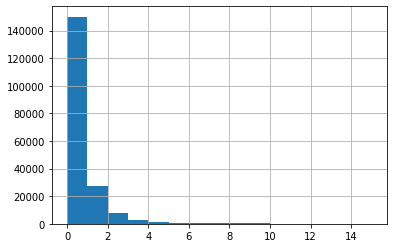

In [7]:
unique_img_ids['ships'].hist(bins=unique_img_ids['ships'].max())

## Undersample Empty Images
Undersample the empty images to get a better balanced group with more ships to try and segment

12824 masks


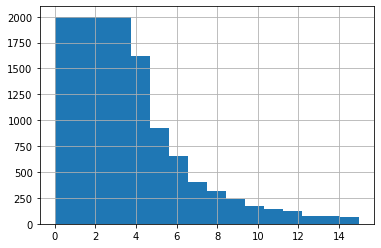

In [8]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [9]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35523 training masks
8886 validation masks


In [10]:
# todo: Augmentation (Keras)

# def get_data(sz,bs):
#     #data augmentation
#     aug_tfms = [RandomRotate(20, tfm_y=TfmType.CLASS),
#                 RandomDihedral(tfm_y=TfmType.CLASS),
#                 RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]
#     tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, 
#                 aug_tfms=aug_tfms)
#     tr_names = tr_n if (len(tr_n)%bs == 0) else tr_n[:-(len(tr_n)%bs)] #cut incomplete batch
#     ds = ImageData.get_ds(pdFilesDataset, (tr_names,TRAIN), 
#                 (val_n,TRAIN), tfms, test=(test_names,TEST))
#     md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
#     md.is_multi = False
#     return md

## RLE (Run-Length Encode and Decode)

ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [11]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' # no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' # ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list, shape=(768, 768)):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros(shape, dtype = np.float32)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) # scale the heatmap image to shift 
    for i, mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask, shape=shape)
    return all_masks

# Split into training and validation groups

In [12]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(TRAIN, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)/1.0
                out_rgb, out_mask=[], []

In [13]:
train_gen = make_image_gen(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (8, 384, 384, 3) 0.0 1.0
y (8, 384, 384, 1) 0.0 1.0


In [14]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(2000, 384, 384, 3) (2000, 384, 384, 1)


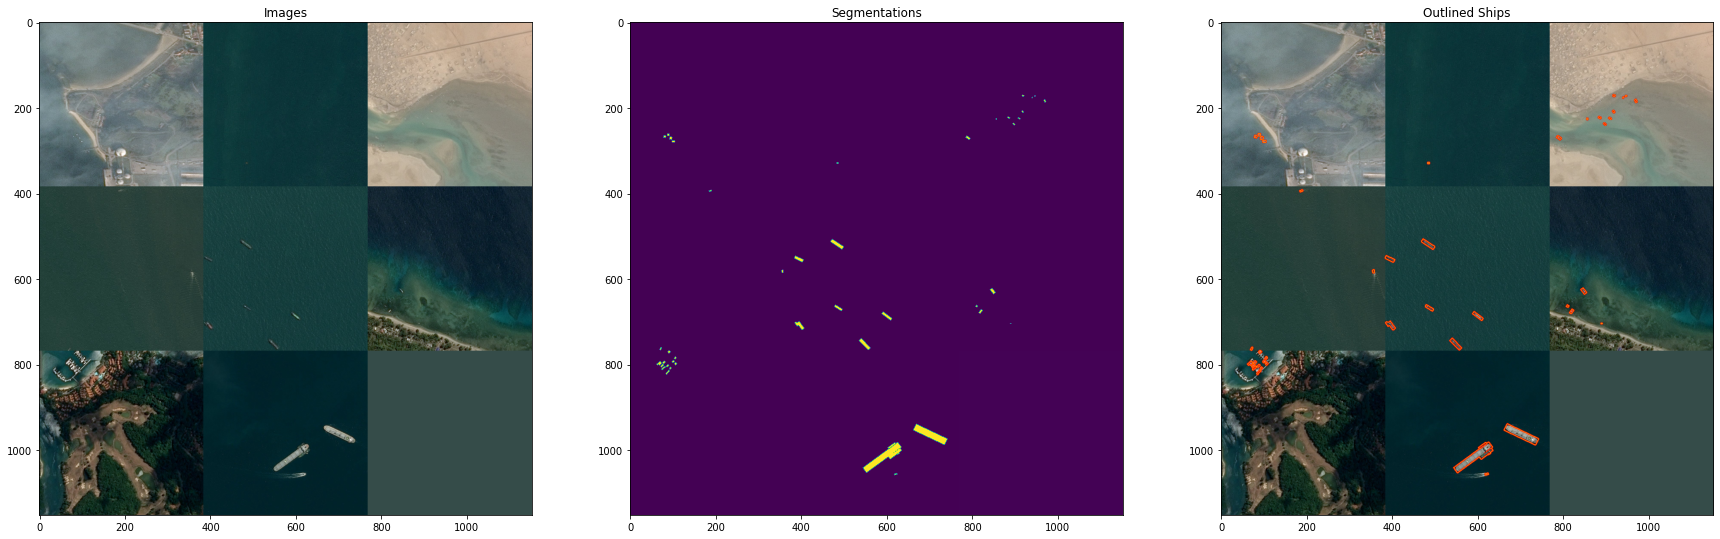

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int),
                           outline_color=(1, 0, 0)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

# Augment Data

In [16]:
dg_args = dict(featurewise_center = False, 
                samplewise_center = False,
                rotation_range = 45, 
                width_shift_range = 0.1, 
                height_shift_range = 0.1, 
                shear_range = 0.01,
                zoom_range = [0.9, 1.25],  
                horizontal_flip = True, 
                vertical_flip = True,
                fill_mode = 'reflect',
                data_format = 'channels_last')


if AUGMENT_BRIGHTNESS:
    dg_args['brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = 42):
    np.random.seed(seed)
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (8, 384, 384, 3) float32 0.0 1.0
y (8, 384, 384, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

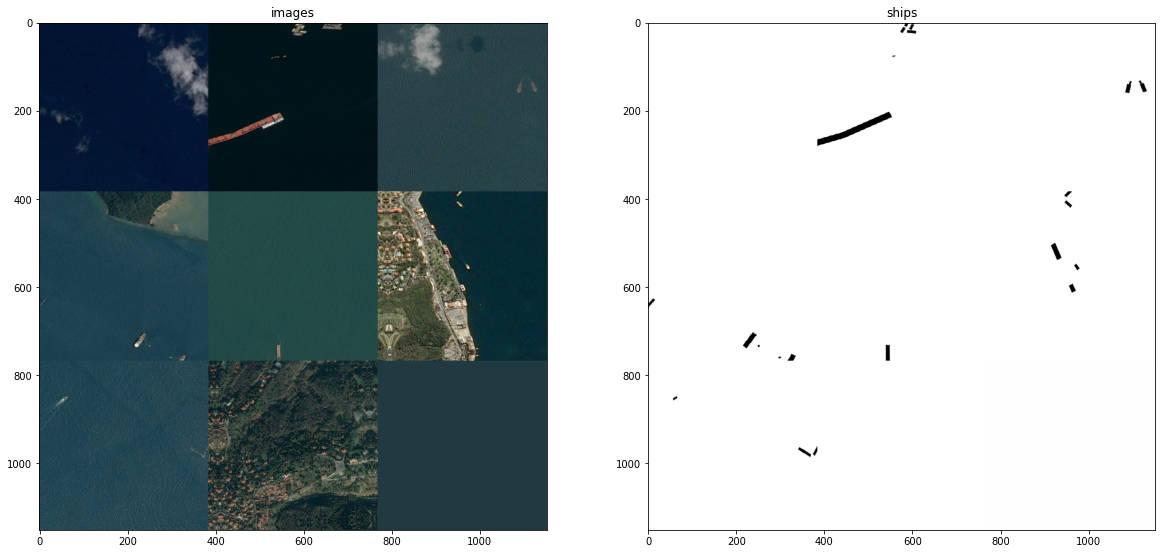

In [17]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

# Build a model

In [18]:
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(train_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img

if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)

# d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
# d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])      
seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d (AveragePool  (None, 384, 384, 3)  0          ['RGB_Input[0][0]']              
 ing2D)                                                                                           
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 384, 384, 3)  0          ['average_pooling2d[0][0]']      
                                                                                              

# Train model

In [19]:
# Intersection over Union
def IoU(y_true, y_pred, eps=1e-6):
    # if K.max(y_true) == 0.0:
    #     return IoU(1-y_true, 1-y_pred)  # empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    return K.mean( (intersection + eps) / (union + eps), axis=0)

In [20]:
def IoU_loss(y_true, y_pred):
    return 1 - IoU(y_true, y_pred)

In [21]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

dice_loss = DiceLoss()

In [22]:
def dice_coef(mask1, mask2):
    intersect = K.sum(mask1*mask2)
    fsum = K.sum(mask1)
    ssum = K.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = K.mean(dice)
    return dice

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="seg_model_weights.best.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.33,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", mode="min", verbose=2,
                      patience=20)

callbacks_list = [checkpoint, early, reduceLROnPlat]

In [24]:
metrics = [IoU, 'binary_accuracy', dice_coef]
metrics_names = [x if isinstance(x, str) else x.__name__ for x in metrics]
loss_func = dice_loss
seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=loss_func, metrics=metrics)

def fit(model):    
    step_count = min(MAX_TRAIN_STEPS, train_df.shape[0]//BATCH_SIZE)
    aug_gen = create_aug_gen(make_image_gen(train_df))
    loss_history = [model.fit(aug_gen,
                              steps_per_epoch=step_count,
                              epochs=MAX_TRAIN_EPOCHS,
                              validation_data=(valid_x, valid_y),
                              callbacks=callbacks_list,
                              workers=1 # the generator is not thread safe
                              )]
    return loss_history

In [25]:
# seg_model2 = tf.keras.models.load_model('./seg_model.h5', compile=False)

In [26]:
%%time
print('Images shape:', train_x.shape[1:])
pass_num = 1
loss_histories = []
last_passes_dice_difference = 1

if MODEL_MODE == "TRAIN":
    while True:
        print(f"Pass #{pass_num}")
        gc.collect()

        try:
            loss_histories.append(fit(seg_model))
        except KeyboardInterrupt:
            break
        
        # break if:
        # - val_loss < 0.4
        # - number of passes > 10
        if np.min([mh.history['val_loss'] for mh in loss_histories[-1]]) < 0.4 or pass_num >= 10:
            break
        pass_num += 1
        
    seg_model.save('seg_model.h5')
    gc.collect()
else:
    if not LOAD_PATH:
        # if LOAD_PATH is None, it takes default value for save
        LOAD_PATH = weight_path
    seg_model.load_weights(LOAD_PATH)
    seg_model.compile(optimizer=Adam(1e-3, decay=1e-6), loss=loss_func, metrics=metrics)

Images shape: (384, 384, 3)
CPU times: total: 46.9 ms
Wall time: 75.1 ms


In [27]:
loss, *acc = seg_model.evaluate(valid_x, valid_y, verbose=2)
accuracies = {metrics_names[i]: acc[i] for i in range(len(acc))}
print(f"Accuracy: {accuracies}%")

63/63 - 18s - loss: 0.3511 - IoU: 0.2437 - binary_accuracy: 0.9954 - dice_coef: 0.4846 - 18s/epoch - 289ms/step
Accuracy: {'IoU': 0.2436901181936264, 'binary_accuracy': 0.9953615665435791, 'dice_coef': 0.48457711935043335}%


In [28]:
pred_y = seg_model.predict(valid_x[:100])
print(pred_y.shape, pred_y.min(axis=0).max(), pred_y.max(axis=0).min(), pred_y.mean())

4/4 [==============================] - 1s 196ms/step
(100, 384, 384, 1) 1.8865262e-07 0.004250242 0.010074814


# Visualize predictions

Show loss and all metrics for all passes

In [29]:

def show_loss(loss_histories, pass_num = 1):
    metrics_names = [x if isinstance(x, str) else x.__name__ for x in metrics]
    metrics_names_size = len(metrics_names)
    histories_size = len(loss_histories)
    fig, m_axs = plt.subplots(histories_size, metrics_names_size+1, figsize=(5*(metrics_names_size+1), histories_size*4))

    # if there was one pass, make it an array from one element
    if histories_size == 1:
        m_axs = [m_axs]

    for axs, loss_history in zip(m_axs, loss_histories):
        # loss_history = loss_histories[i]

        epochs = np.concatenate([mh.epoch for mh in loss_history])

        axs[0].plot(epochs, np.concatenate([mh.history['loss'] for mh in loss_history]), 'b-',
                    epochs, np.concatenate([mh.history['val_loss'] for mh in loss_history]), 'r-')
        axs[0].legend(['Training', 'Validation'])
        axs[0].set_title('Loss')

        for j in range(1, len(metrics_names)+1):
            metric_name = metrics_names[j-1]
            axs[j].plot(epochs, np.concatenate([mh.history[metric_name] for mh in loss_history]), 'b-',
                    epochs, np.concatenate([mh.history[f'val_{metric_name}'] for mh in loss_history]), 'r-')
            axs[j].legend(['Training', 'Validation'])
            axs[j].set_title(metric_name)

if MODEL_MODE == "TRAIN":
    show_loss(loss_histories)

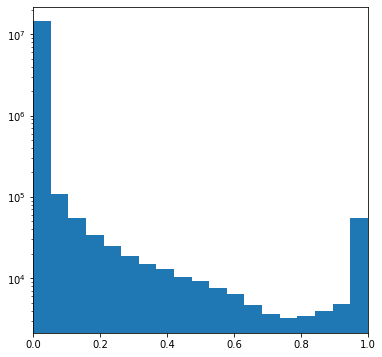

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.hist(pred_y.ravel(), np.linspace(0, 1, 20))
ax.set_xlim(0, 1)
ax.set_yscale('log')

In [31]:
def raw_prediction(c_img_name, path=TEST):
    c_img = imread(os.path.join(path, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    if IMG_SCALING is not None:
        c_img = c_img[:, ::IMG_SCALING[0], ::IMG_SCALING[1]]
    cur_seg = seg_model.predict(c_img)[0]
    return cur_seg, c_img[0]

def smooth(cur_seg):
    return binary_opening(cur_seg>0.99, np.expand_dims(disk(2), -1))

def predict(img, path=TEST):
    cur_seg, c_img = raw_prediction(img, path=path)
    return smooth(cur_seg), c_img

1/1 [==============================] - 0s 17ms/step


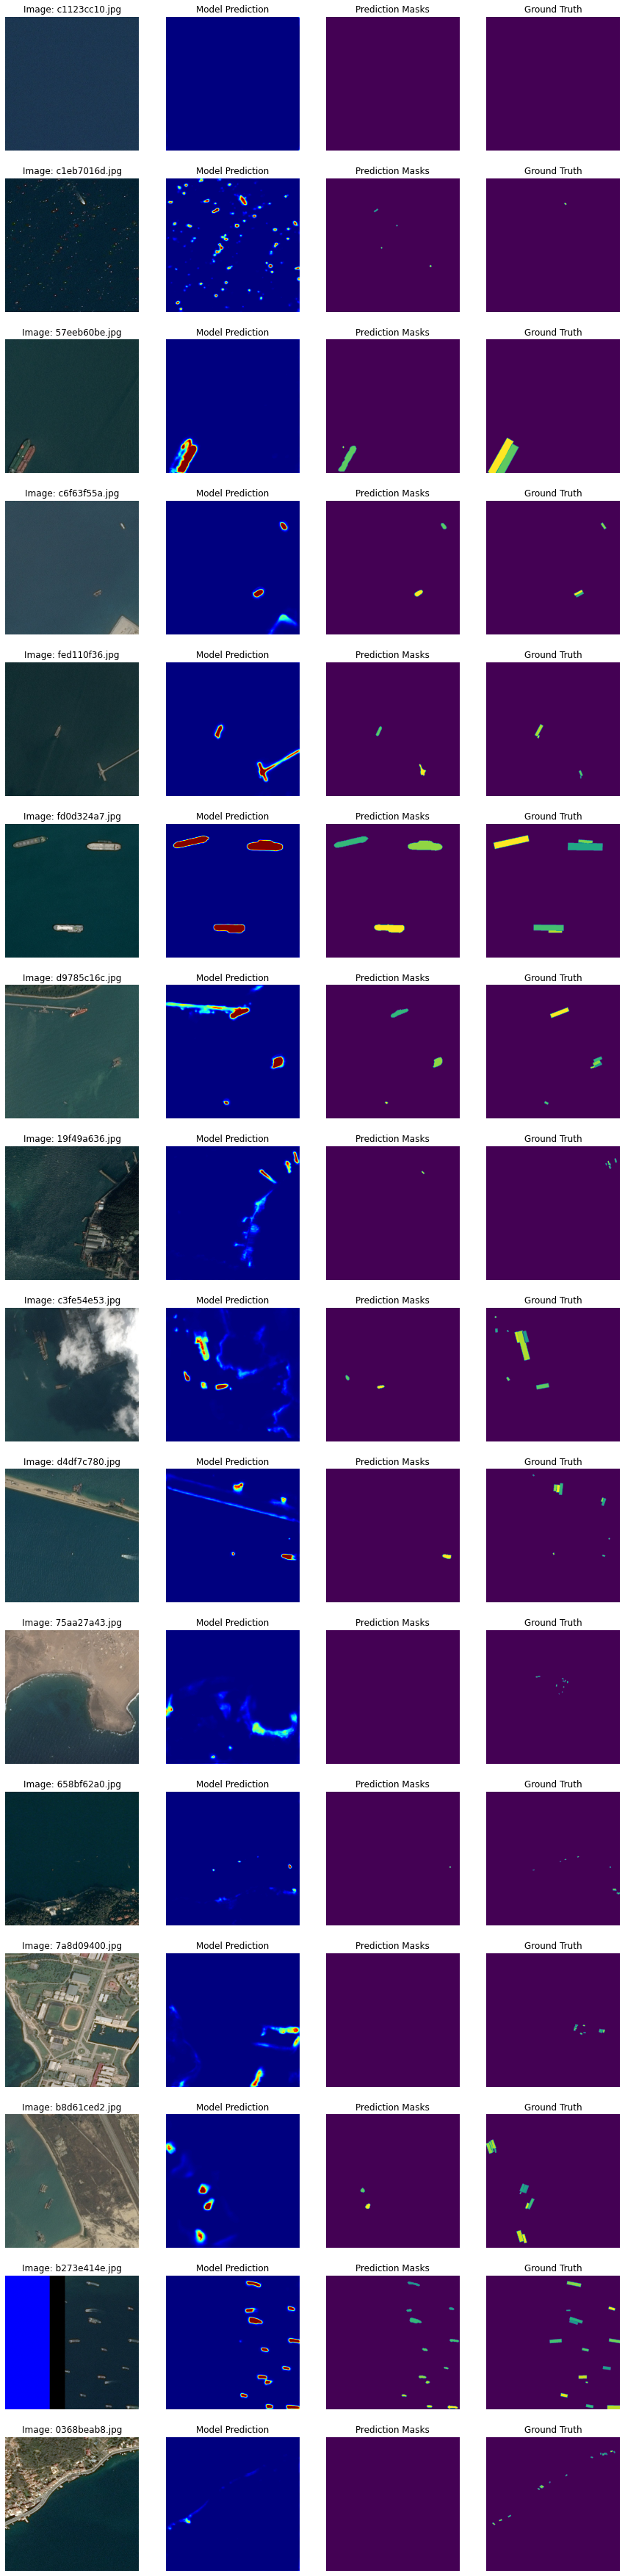

In [32]:
# Get a sample of each group of ship count
samples = valid_df.groupby('ships').apply(lambda x: x.sample(1))
fig, m_axs = plt.subplots(samples.shape[0], 4, figsize = (15, samples.shape[0]*4))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2, ax3, ax4), c_img_name in zip(m_axs, samples.ImageId.values):
    first_seg, first_img = raw_prediction(c_img_name, TRAIN)
    ax1.imshow(first_img)
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(first_seg[:, :, 0], cmap=get_cmap('jet'))
    ax2.set_title('Model Prediction')
    # print(first_seg[::2, ::2].shape[:2])
    reencoded = masks_as_color(multi_rle_encode(smooth(first_seg)[:, :, 0]), shape=first_seg.shape[:2])
    ax3.imshow(reencoded)
    ax3.set_title('Prediction Masks')
    ground_truth = masks_as_color(masks[masks['ImageId'] == c_img_name]['EncodedPixels'])
    ax4.imshow(ground_truth)
    ax4.set_title('Ground Truth')
    
fig.savefig('validation.png')

In [33]:
def DICE_COEF(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3) # for easy reading
    return dice

print(DICE_COEF(valid_y[:100], pred_y[:100]))

0.52


# Submissions

In [34]:
test_paths = np.array(os.listdir(TEST))
print(len(test_paths), 'test images found')

15606 test images found


In [35]:
def pred_encode(img, **kwargs):
    cur_seg, _ = predict(img)
    
    cur_rles = multi_rle_encode(cur_seg, **kwargs)
    return [[img, rle] for rle in cur_rles if rle is not None]

out_pred_rows = []
for c_img_name in test_paths[:1000]: # only a subset as it takes too long to run
    out_pred_rows += pred_encode(c_img_name, min_max_threshold=1.0)

1/1 [==============================] - 0s 16ms/step


In [36]:
subm = pd.DataFrame(out_pred_rows)
subm.columns = ['ImageId', 'EncodedPixels']
subm = subm[subm.EncodedPixels.notnull()]
subm.head()

,ImageId,EncodedPixels
0,000bd9dbf.jpg,105570 2 105953 4 106336 6 106719 8 107103 8 1...
1,0010551d9.jpg,46590 9 46973 12 47356 15 47739 19 48123 21 48...
2,001839c6f.jpg,121390 1 121773 3 122156 5 122540 5 122924 6 1...
3,001839c6f.jpg,19703 1 20086 3 20469 5 20853 5 21236 6 21620 ...
4,001839c6f.jpg,28166 2 28549 4 28932 6 29317 4 29702 2


1/1 [==============================] - 0s 18ms/step


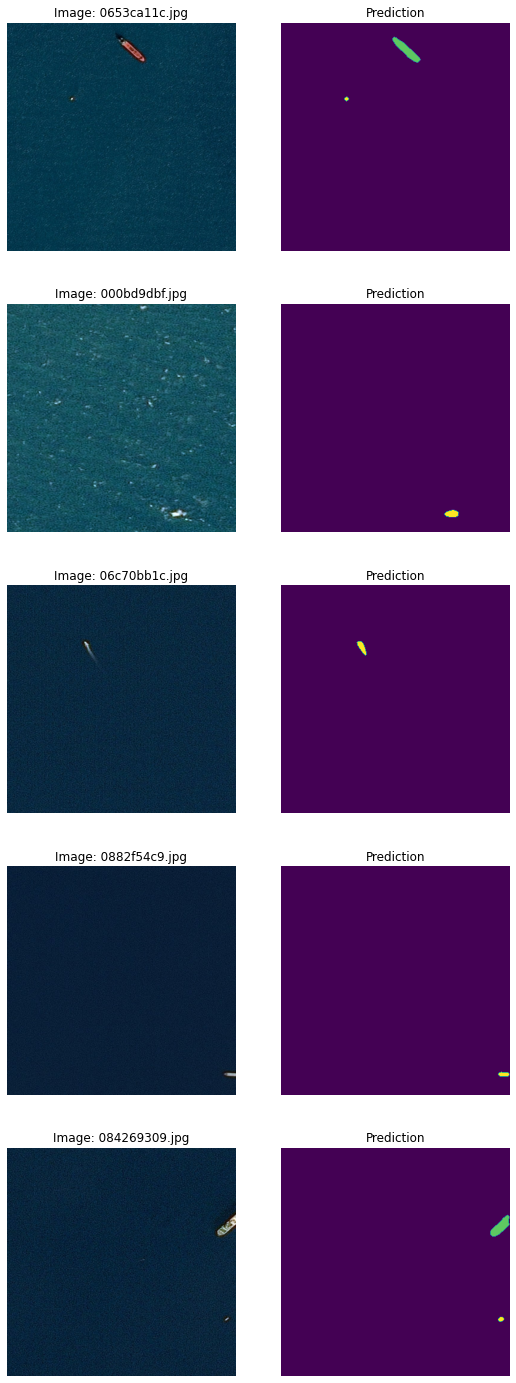

In [37]:
PREDICTIONS_NUM = 5
imgs_shape = predict(test_paths[0])[0].shape[:2]

fig, m_axs = plt.subplots(PREDICTIONS_NUM, 2, figsize = (9, PREDICTIONS_NUM*5))
[c_ax.axis('off') for c_ax in m_axs.flatten()]

for (ax1, ax2), c_img_name in zip(m_axs, np.random.choice(pd.unique(subm["ImageId"]), PREDICTIONS_NUM)):
    c_img = imread(os.path.join(TEST, c_img_name))
    c_img = np.expand_dims(c_img, 0)/255.0
    ax1.imshow(c_img[0])
    ax1.set_title('Image: ' + c_img_name)
    ax2.imshow(masks_as_color(subm[subm['ImageId'] == c_img_name]['EncodedPixels'], shape=imgs_shape))
    ax2.set_title('Prediction')

In [38]:
sub1 = pd.read_csv('airbus-ship-detection/sample_submission_v2.csv')
sub1 = pd.DataFrame(np.setdiff1d(sub1['ImageId'].unique(), subm['ImageId'].unique(), assume_unique=True), columns=['ImageId'])
sub1['EncodedPixels'] = None
print(len(sub1), len(subm))

sub = pd.concat([subm, sub1])
print(len(sub))
sub.to_csv('submission.csv', index=False)
sub.head()

15439 283
15722


,ImageId,EncodedPixels
0,000bd9dbf.jpg,105570 2 105953 4 106336 6 106719 8 107103 8 1...
1,0010551d9.jpg,46590 9 46973 12 47356 15 47739 19 48123 21 48...
2,001839c6f.jpg,121390 1 121773 3 122156 5 122540 5 122924 6 1...
3,001839c6f.jpg,19703 1 20086 3 20469 5 20853 5 21236 6 21620 ...
4,001839c6f.jpg,28166 2 28549 4 28932 6 29317 4 29702 2
